In [14]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm  # For progress bar
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
import pandas as pd

import os

# Paths to predictions, ground truth, and input directories
path_predictions = "/home/fp427/rds/rds-cam-segm-7tts6phZ4tw/mission/nnunet/nnUNet_results/Dataset008_synthseg"
mindboggle_ground_truth_path = "/home/fp427/rds/rds-cam-segm-7tts6phZ4tw/mission/data/mindboggle/ground_truth"
mindboggle_input_path = "/home/fp427/rds/rds-cam-segm-7tts6phZ4tw/mission/data/mindboggle/input"

# Load file lists
input_files = sorted(os.listdir(mindboggle_input_path))
ground_truth_files = sorted(os.listdir(mindboggle_ground_truth_path))
prediction_files = sorted([f for f in os.listdir(path_predictions) if f.endswith('.nii.gz')])

# Load optional .npz probability files
probability_files = sorted([f for f in os.listdir(path_predictions) if f.endswith('.npz')])

# Print counts of each file type
print("Number of input files: ", len(input_files))
print("Number of ground truth files: ", len(ground_truth_files))
print("Number of prediction files: ", len(prediction_files))
print("Number of probability (.npz) files: ", len(probability_files))

# Check if probability files exist
if probability_files:
    # If .npz files are present, ensure their count matches the other file types
    assert len(probability_files) == len(input_files) == len(ground_truth_files) == len(prediction_files), \
        "Mismatch in number of probability (.npz) files compared to input, ground truth, and prediction files."
else:
    # If no .npz files, proceed without them
    print("No probability (.npz) files found. Proceeding without probability data.")

# Ensure that input, ground truth, and prediction files have the same length
assert len(input_files) == len(ground_truth_files) == len(prediction_files), \
    "Mismatch in number of input, ground truth, and prediction files."

# If probability files exist, they have already been validated for matching counts
# Create a list of dictionaries each containing 'input', 'gt', 'prediction', and optionally 'probability'
dataset = []
for idx in range(len(input_files)):
    entry = {
        'input': input_files[idx],
        'gt': ground_truth_files[idx],
        'prediction': prediction_files[idx]
    }
    
    # If probability files exist, add the corresponding .npz file to the entry
    if probability_files:
        entry['probability'] = probability_files[idx]
    
    dataset.append(entry)

# Optional: Print the first few dataset entries for verification
for i, data in enumerate(dataset[:5], 1):
    print(f"Entry {i}: {data}")



Number of input files:  101
Number of ground truth files:  101
Number of prediction files:  101
Number of probability (.npz) files:  101
Entry 1: {'input': 'Afterthought-1.nii.gz', 'gt': 'Afterthought-1.nii.gz', 'prediction': 'synthseg_0000.nii.gz', 'probability': 'synthseg_0000.npz'}
Entry 2: {'input': 'Colin27-1.nii.gz', 'gt': 'Colin27-1.nii.gz', 'prediction': 'synthseg_0001.nii.gz', 'probability': 'synthseg_0001.npz'}
Entry 3: {'input': 'HLN-12-1.nii.gz', 'gt': 'HLN-12-1.nii.gz', 'prediction': 'synthseg_0002.nii.gz', 'probability': 'synthseg_0002.npz'}
Entry 4: {'input': 'HLN-12-10.nii.gz', 'gt': 'HLN-12-10.nii.gz', 'prediction': 'synthseg_0003.nii.gz', 'probability': 'synthseg_0003.npz'}
Entry 5: {'input': 'HLN-12-11.nii.gz', 'gt': 'HLN-12-11.nii.gz', 'prediction': 'synthseg_0004.nii.gz', 'probability': 'synthseg_0004.npz'}


In [11]:


def compute_total_entropy(probabilities: np.ndarray) -> float:
    """
    Computes the total entropy for a given 4D array where the first dimension represents the number of classes 
    and the remaining dimensions correspond to the spatial dimensions of the data.

    Parameters:
    probabilities (np.ndarray): A 4D array of shape (num_classes, height, width, depth) representing class probabilities.

    Returns:
    float: The total entropy of the array.
    """
    if probabilities.ndim != 4:
        raise ValueError("Input probabilities must be a 4D array with shape (num_classes, height, width, depth).")
    
    # Ensure probabilities are non-negative and sum to 1 across the class dimension
    probabilities = np.clip(probabilities, 1e-10, 1.0)  # Avoid log(0) by clipping probabilities to a small positive value
    
    # Calculate the entropy for each voxel 
    entropy = -np.sum(probabilities * np.log2(probabilities), axis=0)
    
    # Sum the entropy across all spatial positions to get the total entropy
    total_entropy = np.sum(entropy)
    
    return total_entropy


(39, 256, 256, 176)
Total Entropy: 2002700.5


In [ ]:


def convert_ground_truth_labels(gt_data):
    """
    Convert the ground truth labels to our limited set of classes.
    """
    converted = np.full_like(gt_data, fill_value=-1, dtype=np.int32)
    converted[gt_data == 0] = 0
    converted[gt_data >= 1000] = 1
    converted[np.isin(gt_data, [2, 41])] = 2
    converted[np.isin(gt_data, [8, 47])] = 3
    converted[np.isin(gt_data, [7, 46])] = 4
    converted[np.isin(gt_data, [4,5, 43, 44])] = 5
    return converted

def convert_prediction_labels(pred_data):
    """
    Convert the prediction labels to the same limited set of classes as ground truth.
    """
    converted = np.full_like(pred_data, fill_value=-1, dtype=np.int32)
    
    # Background
    converted[pred_data == 0] = 0
    # Cerebral cortex gray
    converted[pred_data == 2] = 1
    # Cerebral white
    converted[pred_data == 1] = 2
    # Cerebellar gray
    converted[pred_data == 6] = 3
    # Cerebellar white
    converted[pred_data == 5] = 4
    # Lateral ventricles
    converted[np.isin(pred_data, [3,4])] = 5

    return converted

def compute_dice_scores(dataset, class_names, compute_entropy=True):
    """
    Compute the Dice score for each class for each file in the dataset.
    
    Parameters:
    - dataset (list): List of dictionaries containing 'gt', 'prediction', and optionally 'probability' filenames.
    - class_names (list): List of class names.
    
    Returns:
    - per_class_dice_scores (dict): Lists of Dice scores for each class.
    - total_dice_scores (dict): Total Dice score for each class.
    - df_results (pd.DataFrame): DataFrame containing total dice score and total entropy for each sample.
    """
    # Initialize accumulators for total scores
    intersection = {class_id: 0 for class_id in range(6)}
    gt_sum = {class_id: 0 for class_id in range(6)}
    pred_sum = {class_id: 0 for class_id in range(6)}
    
    # Initialize per-class dice score lists
    per_class_dice_scores = {class_id: [] for class_id in range(6)}
    
    # DataFrame to store total dice score and total entropy for each sample
    df_results = pd.DataFrame(columns=['sample', 'total_dice_score', 'total_entropy'])
    
    for item in tqdm(dataset, desc="Processing files"):
        # Load ground truth and prediction
        gt_path = os.path.join(mindboggle_ground_truth_path, item['gt'])
        pred_path = os.path.join(path_predictions, item['prediction'])
        
        total_entropy = None
        if compute_entropy and 'probability' in item:
            # Get the npz path
            npz_path = item['probability']
            # Load the npz file
            probability_data = np.load(os.path.join(path_predictions, npz_path))
            # Compute total entropy
            total_entropy = compute_total_entropy(probability_data['probabilities'])
        
        gt_img = nib.load(gt_path)
        pred_img = nib.load(pred_path)
        
        gt_data = gt_img.get_fdata()
        pred_data = pred_img.get_fdata()
        
        # Convert labels
        gt_converted = convert_ground_truth_labels(gt_data)
        pred_converted = convert_prediction_labels(pred_data)
        
        sample_dice_scores = []  # Store dice scores for this particular sample
        
        for class_id in range(6):
            gt_mask = (gt_converted == class_id)
            pred_mask = (pred_converted == class_id)
            
            intersection[class_id] += np.sum(gt_mask & pred_mask)
            gt_sum[class_id] += np.sum(gt_mask)
            pred_sum[class_id] += np.sum(pred_mask)
            
            # Compute Dice for this class in the current file
            if np.sum(gt_mask) + np.sum(pred_mask) == 0:
                dice = 1.0  # Perfect score if both GT and prediction have no voxels for this class
            else:
                dice = 2 * np.sum(gt_mask & pred_mask) / (np.sum(gt_mask) + np.sum(pred_mask))
            
            per_class_dice_scores[class_id].append(dice)
            sample_dice_scores.append(dice)
        
        # Compute total dice score as the mean of all class dice scores for the current sample
        total_dice_score = np.mean(sample_dice_scores)
        
        # Append to the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({
            'sample': [item['gt']],
            'total_dice_score': [total_dice_score],
            'total_entropy': [total_entropy]  # Will be None if compute_entropy is False
        })], ignore_index=True)
    
    # Compute total Dice scores for the whole dataset
    total_dice_scores = {}
    for class_id in range(6):
        if gt_sum[class_id] + pred_sum[class_id] == 0:
            dice = 1.0
        else:
            dice = 2 * intersection[class_id] / (gt_sum[class_id] + pred_sum[class_id])
        total_dice_scores[class_id] = dice
        print(f"Class {class_id} ({class_names[class_id + 1]}): Total Dice Score = {dice:.4f}")
    
    return per_class_dice_scores, total_dice_scores, df_results

# Define class names including ignored (-1)
class_names = [
    'Ignored (-1)', 
    'Background (0)', 
    'Cortical gray (1)', 
    'Cortical white (2)', 
    'Cerebellar gray (3)', 
    'Cerebellar white (4)', 
    'Lateral ventricles (5)'
]

# Compute Dice scores across the entire dataset
per_class_dice_scores, total_dice_scores, df_results = compute_dice_scores(dataset, class_names)


Processing files:   0%|          | 0/101 [00:00<?, ?it/s]

<ipython-input-15-af34cd7787d7>:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame({
Processing files:  19%|█▉        | 19/101 [12:48<57:38, 42.18s/it]  

In [ ]:
# save df_results to csv file in /home/fp427/rds/rds-cam-segm-7tts6phZ4tw/mission/entropy_mindboggle_dataset008
df_results.to_csv('/home/fp427/rds/rds-cam-segm-7tts6phZ4tw/mission/entropy_mindboggle_dataset008/df_results.csv', index=False)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

def analyze_entropy_dice_relationship(df_results, plot=True):
    """
    Analyze the relationship between entropy and Dice scores.

    Parameters:
    - df_results (pd.DataFrame): DataFrame containing 'total_dice_score' and 'total_entropy' for each sample.
    - plot (bool): Whether to generate and display plots.

    Returns:
    - analysis_results (dict): Dictionary containing correlation coefficients and p-values.
    """
    # Ensure required columns are present
    required_columns = ['total_dice_score', 'total_entropy']
    for col in required_columns:
        if col not in df_results.columns:
            raise ValueError(f"Column '{col}' is missing from the DataFrame.")

    # Drop rows with missing values in required columns
    df_clean = df_results.dropna(subset=required_columns)
    
    if df_clean.empty:
        raise ValueError("No data available after removing samples with missing values.")

    # Extract variables
    dice_scores = df_clean['total_dice_score']
    entropies = df_clean['total_entropy']

    # Compute Pearson correlation
    pearson_corr, pearson_p = pearsonr(entropies, dice_scores)

    # Compute Spearman correlation
    spearman_corr, spearman_p = spearmanr(entropies, dice_scores)

    analysis_results = {
        'pearson_correlation': pearson_corr,
        'pearson_p_value': pearson_p,
        'spearman_correlation': spearman_corr,
        'spearman_p_value': spearman_p
    }

    if plot:
        # Set the aesthetic style of the plots
        sns.set(style="whitegrid")

        # Create a scatter plot with regression line using Seaborn
        plt.figure(figsize=(10, 6))
        sns.regplot(x='total_entropy', y='total_dice_score', data=df_clean, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        plt.title('Relationship Between Entropy and Dice Score')
        plt.xlabel('Total Entropy')
        plt.ylabel('Total Dice Score')
        plt.tight_layout()
        plt.show()

        # Optionally, create a joint plot
        sns.jointplot(x='total_entropy', y='total_dice_score', data=df_clean, kind='reg', height=8, scatter_kws={'alpha':0.5})
        plt.suptitle('Joint Plot of Entropy vs. Dice Score', y=1.02)
        plt.show()

    return analysis_results

# Assuming you have already computed df_results
# per_class_dice_scores, total_dice_scores, df_results = compute_dice_scores(dataset, class_names)

# Analyze the relationship between entropy and Dice scores
analysis_results = analyze_entropy_dice_relationship(df_results)

# Display the results
print("Correlation Analysis between Entropy and Dice Score:")
print(f"Pearson Correlation: {analysis_results['pearson_correlation']:.4f} (p-value: {analysis_results['pearson_p_value']:.4e})")
print(f"Spearman Correlation: {analysis_results['spearman_correlation']:.4f} (p-value: {analysis_results['spearman_p_value']:.4e})")



In [ ]:


# Optional: Visualization Function
def visualize_example(index):
    example = dataset[index]
    inp_filename = example['input']
    gt_filename = example['gt']
    pred_filename = example['prediction']
    
    # Load and convert data
    inp_path = os.path.join(mindboggle_input_path, inp_filename)
    gt_path = os.path.join(mindboggle_ground_truth_path, gt_filename)
    pred_path = os.path.join(path_predictions, pred_filename)
    
    inp_data = nib.load(inp_path).get_fdata()
    gt_data = convert_ground_truth_labels(nib.load(gt_path).get_fdata())
    pred_data = convert_prediction_labels(nib.load(pred_path).get_fdata())
    
    # Prepare for plotting
    plot_gt = gt_data + 1
    plot_pred = pred_data + 1
    
    # Create a custom colormap for indices [0..6]
    colors = [
        'white',   # ignored (-1)
        'black',   # background (0)
        'gray',    # cortical gray (1)
        'green',   # cortical white (2)
        'red',     # cerebellar gray (3)
        'blue',    # cerebellar white (4)
        'yellow'   # lateral ventricles (5)
    ]
    custom_cmap = ListedColormap(colors)
    
    def show_slice(slice_idx):
        vmin, vmax = -0.5, 6.5

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Input image
        axes[0].imshow(inp_data[:, :, slice_idx], cmap='gray', interpolation='nearest')
        axes[0].set_title("Input image")
        axes[0].axis('off')

        # Ground truth
        im_gt = axes[1].imshow(plot_gt[:, :, slice_idx], cmap=custom_cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        axes[1].set_title("Ground truth")
        axes[1].axis('off')

        # Prediction
        im_pred = axes[2].imshow(plot_pred[:, :, slice_idx], cmap=custom_cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        axes[2].set_title("Prediction")
        axes[2].axis('off')

        # Colorbar

        cbar = fig.colorbar(im_pred, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
        cbar.set_ticks(np.arange(len(class_names)))
        cbar.set_ticklabels(class_names)

        plt.suptitle(f"Slice: {slice_idx} (File index: {index})", fontsize=16)
        plt.show()
    
    interact(show_slice, slice_idx=widgets.IntSlider(min=0, max=plot_gt.shape[2]-1, step=1, value=plot_gt.shape[2]//2))

# Example: Visualize the first file
visualize_example(0)


<ipython-input-7-fa62d079d475>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


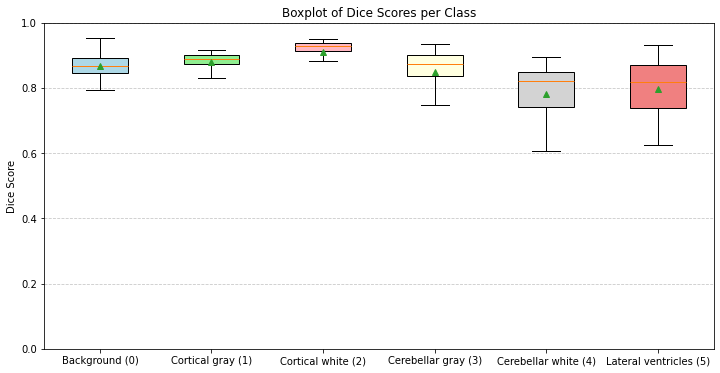

In [ ]:
def plot_dice_boxplot(per_class_dice_scores, class_names):
    """
    Plot a boxplot of Dice scores for each class.
    
    Parameters:
    - per_class_dice_scores (dict): Dictionary with class IDs as keys and lists of Dice scores as values.
    - class_names (list): List of class names.
    """
    # Prepare data for boxplot (exclude the 'Ignored (-1)' class)
    data = [per_class_dice_scores[class_id] for class_id in range(6)]
    labels = [class_names[class_id + 1] for class_id in range(6)]
    
    plt.figure(figsize=(12, 6))
    box = plt.boxplot(
        data, 
        patch_artist=True, 
        labels=labels, 
        showmeans=True,
        showfliers=False  # This line hides the outliers
    )

    # Customize boxplot appearance
    colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightgray', 'lightcoral']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.title('Boxplot of Dice Scores per Class')
    plt.ylabel('Dice Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot the boxplot
plot_dice_boxplot(per_class_dice_scores, class_names)